<h1><center>CS598 Deep Learning for Healthcare Spring 2023<br>Paper Reproduction Project</center></h1>

<h3><center>Gilberto Ramirez and Jay Kakwani<br><span style="font-family:monospace;">{ger6, kakwani2}@illinois.edu</span><br><font color="lightgrey">Group ID: 27 | Paper ID: 181</font></center></h3>

In this project, we aim to reproduce the paper [*Learning Tasks for Multitask Learning: Heterogeneous Patient Populations in the ICU* by (Suresh et al, 2018)](https://arxiv.org/abs/1806.02878). In this paper, the authors propose a novel two-step pipeline to predict in-hospital mortality across patient populations with different characteristics. The first step of the pipeline divides patients into relevant non-overlapping cohorts in an unsupervised way using a long short-term memory (LSTM) autoencoder followed by a Gaussian Mixture Model (GMM). The second step of the pipeline predicts in-hospital mortality for each patient cohort identified in the previous step using an LSTM based multi-task learning model where every cohort is considered a different task.

The paper claims that by applying this pipeline there will be better predictive results when compared to a model applied to the aggregate population using a single task learning model. According to the authors, the better performance given by this pipeline is due to the combination of a multi-task learning model leveraging shared knowledge across distinct patient groups and the way how those groups were created, i.e., identification using a data-driven method rather than relying on domain knowledge or auxiliary labels.

This notebook is structured in four sections:

* [Section 1 (Data)](#section1) details how to take [MIMIC-III data](https://www.nature.com/articles/sdata201635) and preprocess it using functions from our Python library [`mtl_patients.py`](https://github.com/ger6-illini/dl4h-sp23-team27-project/blob/main/code/mtl_patients.py) before moving it through the pipeline. This section also provides data descriptions using functions from our library.
* [Section 2 (Discovering Patient Cohorts)](#section2) runs the first step of the pipeline using the two experiments described by the authors in the paper: 24 hours and 48 hours. Results are shown in two ways: data summaries highlighting resulting class imbalances and sizes, and heatmap plots for selected vitals/lab to make easier a visual comparison of physiological trends between the discovered patient cohorts. This section makes heavy use of the `discover_cohorts()` function in our `mtl_patients.py` library.
* [Section 3 (Predicting In-Hospital Mortality)](#section3) runs the second and most critical part of the pipeline for same two experiments, 24 hours and 48 hours. Here, in-hospital mortality is predicted using a single task baseline model (*global*) and a multi-task learning model (proposed by the authors). Results are shown under two scenarios: without bootstrapping and with bootstrapping (100 samples of the test data set). A summary of the bootstrapping results in a format as close to the original paper (Table 4 and Table 5) as possible is given at the end of the section.
* [Section 4 (References)](#section4) lists all the references used.

After running all the experiments we could corroborate that:
* Step 1 of the pipeline, cohorts discovery, seems to provide cohorts in an unsupervised way with distinct physiological trends. Although results were numerically different from what the authors got, our results are consistent with authors' conclusions.
* Step 2 of the pipeline, mortality prediction, seems to confirm the Multi-Task Learning model has better predictive power than a single task model for the 48 hour experiment. However, our 24 hour experiment did not yield a significant difference between both models. After running additional ablations (documented in other notebooks in [our repo](https://github.com/ger6-illini/dl4h-sp23-team27-project/tree/main/notebooks)), it seems that 18 and 24 hours do not provide enough patient data to provide a prediction where the Multi-task Learning Model is better than the baseline. Our results seem consistent with the idea that a longer observation window leads to better prediction results. In the paper, authors got positive results in the 24 hour experiment but not the 48 hour experiment and attributed the 48 hour results to a heavy bias to missing data.

## 1. <a id='section1'>Data</a>

This paper uses the publicly available [MIMIC-III database](https://www.nature.com/articles/sdata201635) which contains clinical data in a critical care setting. After reviewing the paper in detail, we decided to use [MIMIC-Extract](https://arxiv.org/abs/1907.08322), an open source pipeline by (Wang et al., 2020) for transforming the raw EHR data into usable [Pandas](https://pandas.pydata.org/) dataframes containing hourly time series of vitals and laboratory measurements after performing unit conversion, outlier handling, and aggregation of semantically similar features.

Unfortunately, the MIMIC-Extract pipeline misses two features the [paper code](https://github.com/mit-caml/multitask-patients) makes use of:
* `timecmo_chart` which indicates the timestamp of a patient after being declared in CMO (Comfort Measures Only) state. This feature comes from a MIMIC-III concept table called `code_status`.
* `sapsii` which contains the SAPS (Simplified Acute Physiology Score) II for the patient. This feature comes from another MIMIC-III concept table called `sapsii`.

As a result, there are three data files needed to run this notebook:
* `all_hourly_data.h5`, an HDF file resulting from running the MIMIC-Extract pipeline which is publicly available in GCP using [this link](https://console.cloud.google.com/storage/browser/mimic_extract) and referenced in the [MIMIC-Extract github repo](https://github.com/MLforHealth/MIMIC_Extract).
* `code_status.csv`, a CSV file holding the MIMIC concept table `CODE_STATUS` that can be generated following the instructions in [this link within the MIT-LCP github repo](https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/concepts#generating-the-concepts-in-postgresql).
* `sapsii.csv`, a CSV file holding the MIMIC concept table `SAPSII` that can be generated following the instructions in [this link within the MIT-LCP github repo](https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/concepts#generating-the-concepts-in-postgresql).

The functions used in this notebook assume the three files listed above are in the folder `../data/` by default. However, location can be changed using arguments to the functions that process the data.

All code needed to replicate the paper is in [our github repo](https://github.com/ger6-illini/dl4h-sp23-team27-project) inside a Python module called `mtl_patients`.

The first function from that module we will start using is `get_summaries()`. This function returns three summaries as dataframes:
1. A summary providing some statistics of all patients broken by careunit.
2. A summary providing some statistics of all patients broken by SAPS-II score quartile.
3. A summary providing some statistics of the 29 distinct physiological measurements used in the paper.

These summaries need two arguments to be created:
* `cutoff_hours` (default 24) which is the minimum number of hours a patient needs to stay in the ICU to be considered part of a cohort.
* `gap_hours` (default 12) which is the number of hours between the end of `cutoff_hours` and the moment a model can start making a mortality prediction.

The importance of these two arguments is his impact in the exception criteria used in the paper. In particular, the paper:
1. Excludes all patients that met the in-hospital mortality criteria before `cutoff period` + `gap period`.
2. Excludes patients that were discharged before `cutoff period` + `gap period`.

The in-hospital mortality criteria used in the paper is an extended one and not just considers patients who died but also patients with a CMO (Comfort Measures Only) note. That is considered in the summaries creation as well.

### 1.1. Summaries, 24 hours (cutoff period) + 12 hours (gap period)

Now let's run the `get_summaries()` function with `cutoff_hours` = 24 and `gap_hours` = 12:

In [1]:
# store/print start time to measure runtime
from datetime import datetime
starttime = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f'Start time: {starttime}')

Start time: 29/04/2023 11:09:28


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import sys
pathname = "../code/"
if pathname not in sys.path:
    sys.path.append("../code/")
pd.options.display.max_rows = 999

from mtl_patients import get_summaries

2023-04-29 11:09:33.171902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# install `pytables` using `pip` if running from Paperspace since TensorFlow image does not have it
!pip install tables

In [4]:
%%time
pat_summ_24_by_cu_df, pat_summ_24_by_sapsiiq_df, vitals_labs_summ_24_df = get_summaries(cutoff_hours=24, gap_hours=12)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Creating summaries
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Merging dataframes to create X_full...
    Creating summary by careunit...
    Creating summary by SAPS II score quartile...
    Creating summary by vitals/labs...
    Done!
CPU times: user 7.77 s, sys: 1.99 s, total: 9.76 s
Wall time: 10.4 s


Let's now display the resulting summaries one at a time.

#### 1.1.1. Data summary by patients in each intensive care unit (ICU)

In [5]:
pat_summ_24_by_cu_df

,N,n,Class Imbalance,Age (Mean),Gender (Male)
Careunit,,,,,
CCU,4907,344,0.070,82.56,0.58
CSRU,6971,139,0.020,69.49,0.67
MICU,11403,1138,0.100,77.97,0.51
SICU,5187,409,0.079,72.65,0.52
TSICU,4245,291,0.069,67.20,0.61
Overall,32713,2321,0.071,74.61,0.57


In the previous summary, patients were broken in groups where each group is one of five careunits where patients were first admitted:
* CCU: Coronary Care Unit
* CSRU: Cardiac Surgery Recovery Unit
* MICU: Medical Intensive Care Unit
* SICU: Surgical Intensive Care Unit
* TSICU: Trauma Surgical Intensive Care Unit

In addition, an overall group was also added. The statistics provided by the summary are:
* `N`: The number of samples (patients) in the group.
* `n`: The number of samples (patients) meeting the in-hospital mortality criteria defined in the paper: patient died or had a note of "Do Not Resuscitate" (DNR) or had a note of "Comfort Measures Only" (CMO).
* `Class Imbalance`: Ratio of patients meeting the in-hospital mortality criteria defined in the paper, i.e., $\dfrac{\text{n}}{\text{N}}$.
* `Age (Mean)`: Mean age of patients for each group in years.
* `Gender (Male)`: Ratio of patients that are males.

This summary was prepared to match Table 1 in the original paper. There are differences between both that can be attributed to the way how data was preprocessed by MIMIC-Extract when compared to the preprocessing done by the authors back in 2018, before MIMIC-Extract became available, and that was not made available by the authors in [their code](https://github.com/mit-caml/multitask-patients).

#### 1.1.2. Data summary by patients in each SAPS-II score quartile

In [6]:
pat_summ_24_by_sapsiiq_df

,N,n,Class Imbalance,Age (Mean),Gender (Male),SAPS II (Min),SAPS II (Mean),SAPS II (Max)
SAPS II Quartile,,,,,,,,
0,7099,62,0.009,45.69,0.61,0,16.61,22
1,10033,259,0.026,68.94,0.58,23,27.74,32
2,8127,552,0.068,86.52,0.55,33,36.72,41
3,7454,1448,0.194,96.80,0.54,42,51.42,118
Overall,32713,2321,0.071,74.61,0.57,0,32.95,118


In the previous summary, patients were broken based on the quartile of the SAPS-II score assigned to them. As it can be seen, the four quartiles have the ranges $[0, 22], [23, 32], [33, 41], [42, 118] $. This was included in the authors code but not in the paper. It seems the class imbalance might have been the primary reason. As it is evident from the summary, most of the patients are in quartile $3$ since they are in an ICU and is expected their values are on the high side.

#### 1.1.3. Data summary for physiological measurements

In [7]:
vitals_labs_summ_24_df

,min,avg,max,std,N,pres.
variable,,,,,,
anion gap,5.00,13.62,50.00,3.84,178506,0.0832
bicarbonate,0.00,24.32,53.00,4.68,187223,0.0873
blood urea nitrogen,0.00,26.07,250.00,21.63,189120,0.0882
chloride,50.00,105.19,175.00,6.26,205674,0.0959
creatinine,0.10,1.39,46.60,1.48,189944,0.0886
diastolic blood pressure,0.00,60.95,307.00,14.08,1866709,0.8703
fraction inspired oxygen,0.21,0.53,1.00,0.19,95643,0.0446
glascow coma scale total,3.00,12.59,15.00,3.50,367332,0.1713
glucose,33.00,140.03,1591.00,56.29,502487,0.2343


In the previous summary, all vitals and lab measurements selected in the paper (29 in total) are listed with relevant statistics associated to it:
* `min` representing the minimum of the measurement observed in the vitals/labs.
* `avg` representing the average of the measurement observed in the vitals/labs.
* `max` representing the maximum of the measurement observed in the vitals/labs.
* `std` representing the standard deviation of the measurement observed in the vitals/labs.
* `N` representing the number of non `NaN` samples for the specific vital/lab measurement.
* `pres.` representing the portion of all possible hours across all patients, admissions, and ICU stays where at least one of the 104 vitals/labs measurements in the original MIMIC-Extract pipeline was taken.

All these measurements are based on the `vitals_labs_mean` dataframe in the MIMIC-Extract pipeline which provides average of vitals/labs on a per hour basis for each patient after going into an ICU.

### 1.2. Summaries, 48 hours (cutoff period) + 24 hours (gap period)

Now let's run the `get_summaries()` function with `cutoff_hours` = 48 and `gap_hours` = 24:

In [8]:
%%time
pat_summ_48_by_cu_df, pat_summ_48_by_sapsiiq_df, vitals_labs_summ_48_df = get_summaries(cutoff_hours=48, gap_hours=24)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Creating summaries
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Merging dataframes to create X_full...
    Creating summary by careunit...
    Creating summary by SAPS II score quartile...
    Creating summary by vitals/labs...
    Done!
CPU times: user 6.93 s, sys: 1.11 s, total: 8.04 s
Wall time: 8.18 s


#### 1.2.1. Data summary by patients in each intensive care unit (ICU)

In [9]:
pat_summ_48_by_cu_df

,N,n,Class Imbalance,Age (Mean),Gender (Male)
Careunit,,,,,
CCU,4403,258,0.059,83.28,0.58
CSRU,6865,110,0.016,69.44,0.67
MICU,10409,866,0.083,78.47,0.51
SICU,4815,303,0.063,72.88,0.51
TSICU,3950,202,0.051,67.35,0.60
Overall,30442,1739,0.057,74.80,0.57


#### 1.2.2. Data summary by patients in each SAPS-II score quartile

In [10]:
pat_summ_48_by_sapsiiq_df

,N,n,Class Imbalance,Age (Mean),Gender (Male),SAPS II (Min),SAPS II (Mean),SAPS II (Max)
SAPS II Quartile,,,,,,,,
0,6340,47,0.007,45.90,0.61,0,16.65,22
1,9402,203,0.022,68.66,0.58,23,27.78,32
2,7766,439,0.057,86.51,0.55,33,36.72,41
3,6934,1050,0.151,96.45,0.53,42,51.00,110
Overall,30442,1739,0.057,74.80,0.57,0,33.03,110


#### 1.2.3. Data summary for physiological measurements

In [11]:
vitals_labs_summ_48_df

,min,avg,max,std,N,pres.
variable,,,,,,
anion gap,5.00,13.51,50.00,3.72,170026,0.0826
bicarbonate,0.00,24.41,53.00,4.63,178469,0.0867
blood urea nitrogen,0.00,26.02,250.00,21.60,180302,0.0876
chloride,50.00,105.19,175.00,6.22,196370,0.0954
creatinine,0.10,1.38,46.60,1.48,181105,0.0880
diastolic blood pressure,0.00,60.96,307.00,14.04,1797292,0.8729
fraction inspired oxygen,0.21,0.53,1.00,0.19,91864,0.0446
glascow coma scale total,3.00,12.67,15.00,3.42,352443,0.1712
glucose,33.00,139.72,1591.00,55.49,485940,0.2360


## 2. <a id='section2'>Discovering Patient Cohorts</a>

The paper uses a two-step pipeline to: 1) identify relevant patient cohorts, and 2) use those relevant cohorts as separate tasks in a multi-lask learning framework to predict in-hospital mortality. In this section, we will focus on the first step of the pipeline, i.e., patient cohort discovery.

In order to identify meaningful patient cohorts, the paper proposes to process the raw patient data in such a way that the result is a 3D matrix of shape $(P \times T \times F)$ where $P$ represents the number of patients, $T$ the number of timesteps, and $F$ the number of features as depicted in the figure below (in blue) which is partially based on Figure 2 of the original paper. All numbers shown in the figure below correspond to a specific experiment published in the paper in which the observation window is limited to the first $24$ hours (cutoff period) after a patient goes into a careunit and there is a gap of $12$ hours (gap period) between the end of the observation window and the beginning of the prediction window where the prediction task is in-hospital mortality.

Preparation of the data to get the 3D (blue) matrix is performed by a function called `prepare_data()` inside the `mtl_patients.py` module. This preparation consists of the following transformations taken from the paper and the author's code reference implementation:
1. Calculation of the mortality flag (prediction label) and mortality time for every patient in the dataset using an *extended* definition of mortality: death, a note of "Do Not Resuscitate" (DNR), or a note of "Comfort Measures Only" (CMO). In case any of these conditions are met for a patient, the corresponding mortality label is set to *True* and the corresponding mortality time is considered as the earliest time of any of the three conditions. After reviewing in detail the author's code implementation it seems mortality is based on deathtime and a CMO note but not DNR. However, the calculation of the time of death is based on the earliest time of the three conditions.
2. Data used for the prediction is only limited to the first certain amount of hours after a patient goes into the ICU. This amount of hours is called inside the code "a cutoff period" (observation window) and defines the period of data used to train all models. In addition, there is another number of hours called inside the code "the gap period" which represents the time between the end of the observation window and the beginning of the prediction window to prevent label leakage. All patients that died under the *extended* definition before the cutoff period plus the gap period or stayed less than the cutoff period are excluded from the experiment as part of this step. Also, all patients under the age of 15 are excluded (this is already part of the exclusion criteria of the MIMIC-Extract pipeline).
3. There are 29 vitals/labs timeseries selected by the paper. Only data within the cutoff period for vitals/labs is kept and rest is removed. This will be used for the rest of the machine learning pipeline.
4. All vitals/labs values are converted to z-scores so they all have zero mean and unit standard deviation. Those z-scores are rounded to the closest integer and clipped between $-4$ and $4$ or set to $9$ in case of `NaN`. This allows to map every vital/lab measurement (a float) to one of ten possible values $[-4, -3, -2, -1, 0, 1, 2, 3, 4, 9]$, so they can be converted to dummy values. After dummifying the vitals/labs, column for the $9$ values (`NaN`) is removed, and the resulting matrix is sparse and containing either $0$s or $1$s.
5. Every patient is padded with rows of zeroes for those hours that are missed. For example, if a patient only has vitals/labs for the first ten hours and the cutoff period is 24, code adds fourteen hours (rows) with zeroes for that patient. In the end, the matrix will have a size of $P \times T \times F$ as expected by the subsequent models.
6. Finally, static data (gender, age, and ethnicity) is converted to integers representing categories and dummified. In case of age, there are four buckets established; $(10, 30), (30, 50), (50, 70), (70, \infty)$; while ethnicity is broken into five buckets (asian, white, hispanic, black, other).
7. Cohort assignments based on first careunit or Simplified Acute Physiology Score (SAPS) II score quartile is calculated for each patient and returned as well.

![Figure 1](../img/paper-181-fig-1.png)

The `discover_cohorts()` function inside the `mtl_patients.py` module is the one implementing the pipeline shown in the figure above and then calling the `prepare_data()` function detailed previously as the first step. Once data has been processed, the function will break the data in training, validation, and test data sets in a $70\%/10\%/20\%$ proportion.

The training data is used to train an LSTM autoencoder. The main purpose of the LSTM autoencoder is to generate a fixed-length dense representation (embedding) of the sparse inputs trying to retain the most important parts of the inputs. The paper selected embeddings of size $100$ as the optimal dimension (hyperparameter). The purple box in the middle of the diagram above (a 2D matrix) represents the embeddings after the LSTM autoencoder learned the representation of the original 3D matrix of shape $(32537 \times 24 \times 232)$ where every row corresponds to a patient.

Once the embeddings are calculated, a Gaussian Mixture Model is applied using $3$ clusters (the value the authors considered optimal). The result are the three green boxes representing three cohorts discovered in an unsupervised way and grouping similar patients based on the three static and the 29 time-varying vitals/labs selected from the MIMIC-III database.

### 2.1. Cohort statistics at 24 hours and 48 hours

The paper runs two experiments. The first experiment uses a cutoff period of 24 hours, a gap period of 12 hours, and three clusters. Let's run this first experiment using the `discover_cohorts()` function and determine the corresponding cohort assignment for every patient that does not meet the exception criteria.

In [12]:
from mtl_patients import discover_cohorts

In [13]:
%%time
cohort_unsupervised_24 = discover_cohorts(cutoff_hours=24, gap_hours=12, num_clusters=3, embedding_dim=100, cohort_unsupervised_filename='../data/unsupervised_clusters_24.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!
+

2023-04-29 11:10:55.218812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


    Training LSTM autoencoder started at 29/04/2023 11:10:55. This will take several minutes (5 to 25). Please be patient...
Epoch 1/100
179/179 [==============================] - 46s 246ms/step - loss: 0.0384 - val_loss: 0.0325
Epoch 2/100
179/179 [==============================] - 43s 242ms/step - loss: 0.0295 - val_loss: 0.0275
Epoch 3/100
179/179 [==============================] - 44s 244ms/step - loss: 0.0266 - val_loss: 0.0258
Epoch 4/100
179/179 [==============================] - 43s 242ms/step - loss: 0.0254 - val_loss: 0.0250
Epoch 5/100
179/179 [==============================] - 43s 242ms/step - loss: 0.0248 - val_loss: 0.0245
Epoch 6/100
179/179 [==============================] - 43s 243ms/step - loss: 0.0244 - val_loss: 0.0242
Epoch 7/100
179/179 [==============================] - 44s 243ms/step - loss: 0.0241 - val_loss: 0.0240
Epoch 8/100
179/179 [==============================] - 44s 243ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 9/100
179/179 [======================

The second experiment uses a cutoff period of 48 hours, a gap period of 24 hours, and two instead of three clusters. The reduction in the number of clusters is proposed by the authors (Table 3 of the paper). Let's run now this second experiment using the `discover_cohorts()` function and determine the corresponding cohort assignment for every patient that does not meet the exception criteria.

In [14]:
%%time
cohort_unsupervised_48 = discover_cohorts(cutoff_hours=48, gap_hours=24, num_clusters=2, embedding_dim=100, cohort_unsupervised_filename='../data/unsupervised_clusters_48.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!
+

Let's summarize the results of the 24 hour and 48 hour experiments similar to what Table 3 of the paper shows.

In [15]:
#----------------------------------------------------
# Let's create the summary for the 24 hour experiment

cohort_unsupervised_24 = np.load('../data/unsupervised_clusters_24.npy')

from mtl_patients import prepare_data
_, Y, _, _, subject_ids = prepare_data(cutoff_hours=24, gap_hours=12)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!


In [16]:
subject_ids = np.array(subject_ids.tolist())
cohort_unsupervised_24_df = pd.DataFrame({'subject_id': subject_ids, 'Y': Y, 'Group': cohort_unsupervised_24}, dtype=int)

# calculate summaries per cohort (24 hours)
table3_a_df = cohort_unsupervised_24_df.groupby('Group').agg(
    N=('Y', 'size'),
    n=('Y', 'sum'),
)
table3_a_df.loc[:, 'Experiment'] = '24 hours'
table3_a_df.loc[:, 'Cohort Type'] = 'Unsupervised'

# calculate overall summary (24 hours)
table3_a_overall_df = table3_a_df.groupby(['*'] * len(table3_a_df)).agg(
    N=('N', 'sum'),
    n=('n', 'sum'),
)
table3_a_overall_df.index.name = 'Group'
table3_a_overall_df.loc[:, 'Experiment'] = '24 hours'
table3_a_overall_df.loc[:, 'Cohort Type'] = 'Global'

# merge 24 hour tables and make cosmetic changes
table3_a_df = pd.concat([table3_a_df, table3_a_overall_df], axis=0)
table3_a_df.reset_index(inplace=True)
table3_a_df.set_index(['Experiment', 'Cohort Type', 'Group'], inplace=True)

In [17]:
#----------------------------------------------------
# Let's create the summary for the 48 hour experiment

cohort_unsupervised_48 = np.load('../data/unsupervised_clusters_48.npy')

_, Y, _, _, subject_ids = prepare_data(cutoff_hours=48, gap_hours=24)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!


In [18]:
subject_ids = np.array(subject_ids.tolist())
cohort_unsupervised_48_df = pd.DataFrame({'subject_id': subject_ids, 'Y': Y, 'Group': cohort_unsupervised_48}, dtype=int)

# calculate summaries per cohort (48 hours)
table3_b_df = cohort_unsupervised_48_df.groupby('Group').agg(
    N=('Y', 'size'),
    n=('Y', 'sum'),
)
table3_b_df.loc[:, 'Experiment'] = '48 hours'
table3_b_df.loc[:, 'Cohort Type'] = 'Unsupervised'

# calculate overall summary (48 hours)
table3_b_overall_df = table3_b_df.groupby(['*'] * len(table3_b_df)).agg(
    N=('N', 'sum'),
    n=('n', 'sum'),
)
table3_b_overall_df.index.name = 'Group'
table3_b_overall_df.loc[:, 'Experiment'] = '48 hours'
table3_b_overall_df.loc[:, 'Cohort Type'] = 'Global'

# merge 48 hour tables and make cosmetic changes
table3_b_df = pd.concat([table3_b_df, table3_b_overall_df], axis=0)
table3_b_df.reset_index(inplace=True)
table3_b_df.set_index(['Experiment', 'Cohort Type', 'Group'], inplace=True)

In [19]:
#--------------------------------------------------------------------
# Now let's merge results for 24 and 48 hour experiments in one table

# merge 24 hour and 48 hour tables
table3_df = pd.concat([table3_a_df, table3_b_df], axis=0)

# calculate class imbalance
table3_df.loc[:, 'Class Imbalance'] = table3_df.loc[:, 'n'] / table3_df.loc[:, 'N']
table3_df.loc[:, 'Class Imbalance'] = table3_df.loc[:, 'Class Imbalance'].round(4)

In [20]:
table3_df

N     n  Class Imbalance
Experiment Cohort Type  Group                              
24 hours   Unsupervised 0       7428   389           0.0524
                        1      14418  1374           0.0953
                        2      10867   558           0.0513
           Global       *      32713  2321           0.0710
48 hours   Unsupervised 0      17301   925           0.0535
                        1      13141   814           0.0619
           Global       *      30442  1739           0.0571

Table above is the equivalent to Table 3 in the paper. We can see the results are different. Data from MIMIC-Extract might be different from the data used by the authors.

For the 24 hours experiment, size of the clusters are different and mortality as well. For instance, clusters 0 and 2 are smaller compared to cluster 2 but the mortality rate is also half (5.24% and 5.13% versus 9.53%). For the 48 hours experiment, size and mortality of the two resulting clusters are closer when compared to the results from the 24 hour experiment.

### 2.2. Visualization of selected lab test and vital signs features

In this section, we will try to reproduce the results from Figure 4 (section 6.1.1) in the paper. In Figure 4, data from experiment 1 (24 hours) is used to create heatmap plots to determine if patients from different cohorts are physiologically distinct. To do that, we added the function `get_heatmap_data()` to get the mean of all z-scores by patient, by hour in the ICU, by cohort. LSTM autoencoder was set up to use an embedding of size 100 (optimal value according to authors).

#### 2.2.1. Heatmap plots for experiment 1 (24 hours)

Let's run the `get_heatmap_data()` function using the cohorts discovered in experiment 1 (24 hour cutoff period and 12 hour gap period):

In [21]:
%%time

from mtl_patients import get_heatmap_data
import seaborn as sns
import matplotlib.pyplot as plt

labs_df, vitals_df = get_heatmap_data(cutoff_hours=24, gap_hours=12,
                                      cohort_unsupervised_filename='../data/unsupervised_clusters_24.npy')

CPU times: user 3.65 s, sys: 1.28 s, total: 4.93 s
Wall time: 6.77 s


Let's plot the heatmaps for the selected lab tests and vitals:

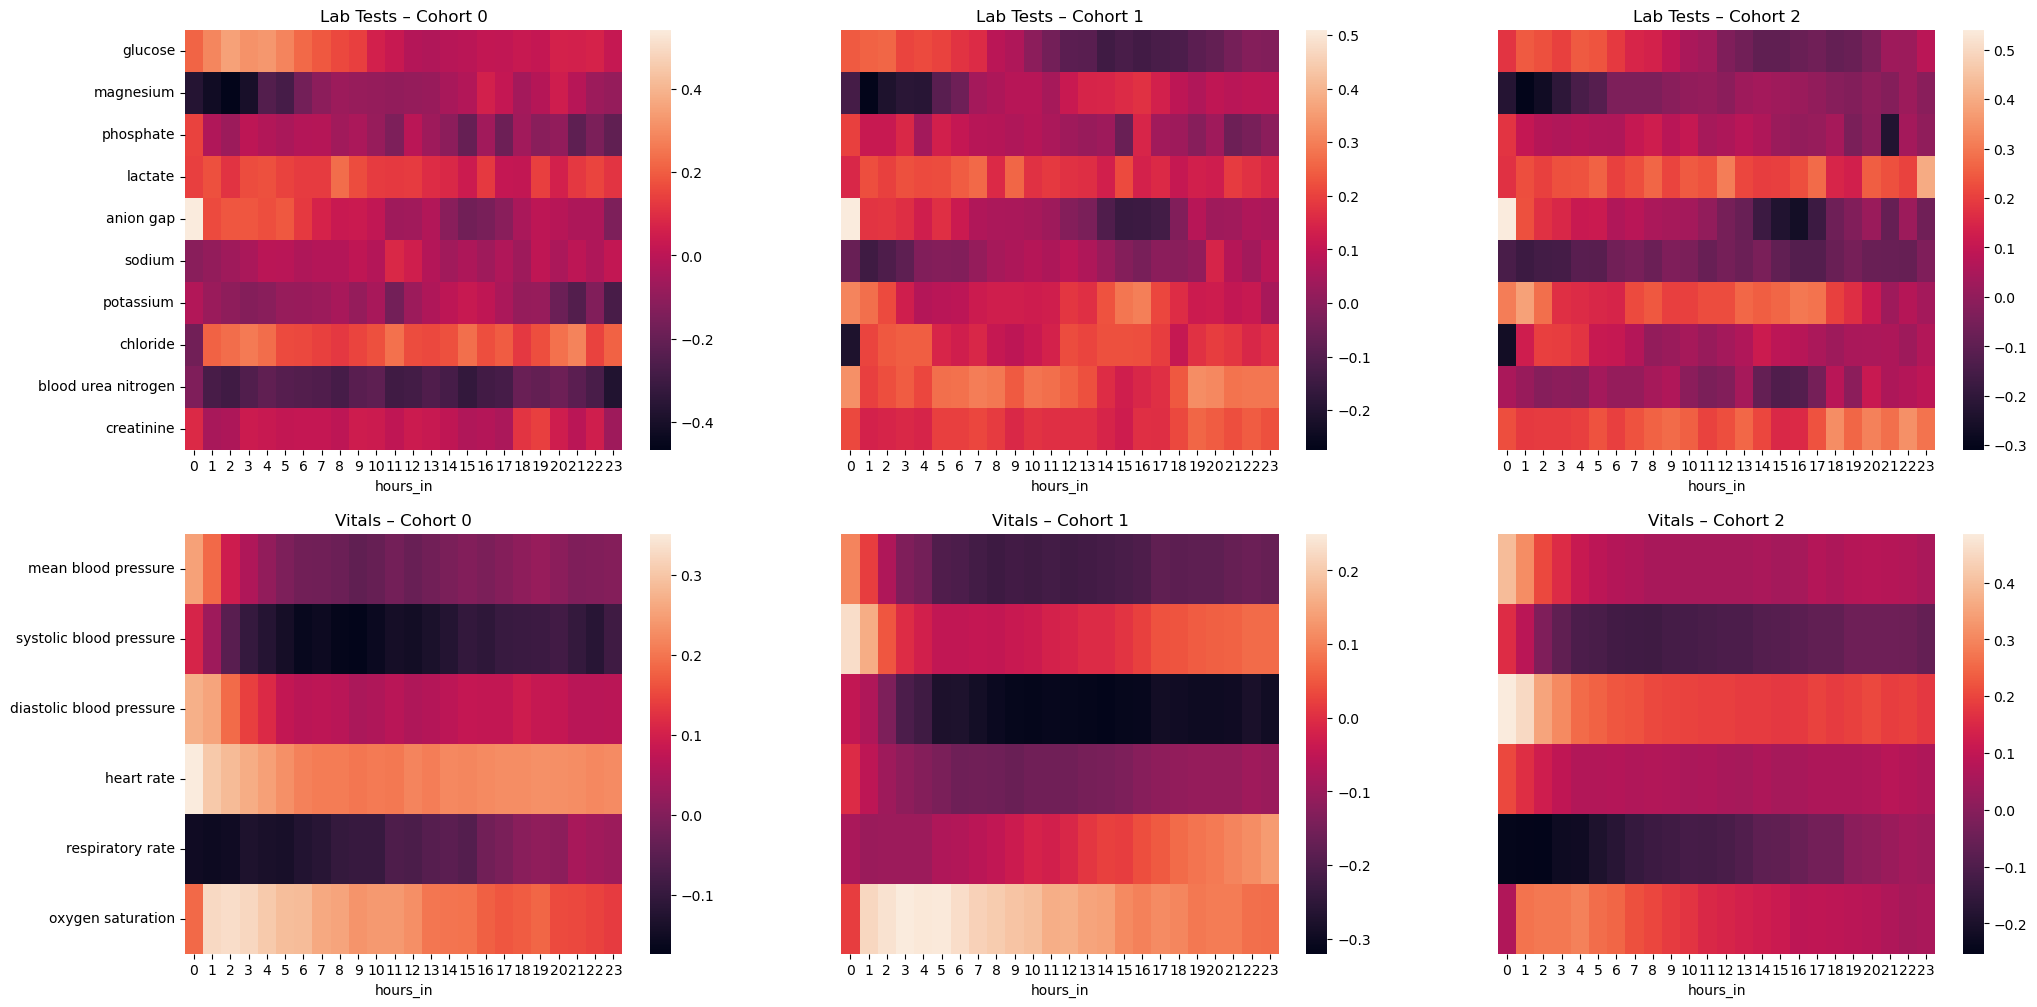

In [22]:
num_cohorts = len(np.unique(labs_df.index.get_level_values(0)))
fig, axs = plt.subplots(nrows=2, ncols=num_cohorts)
fig.set_size_inches(24, 12)
for i in np.arange(num_cohorts):
    plot_df = labs_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[0, i], yticklabels=True if i==0 else False).set(title=f'Lab Tests – Cohort {i}')
for i in np.arange(num_cohorts):
    plot_df = vitals_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[1, i], yticklabels=True if i==0 else False).set(title=f'Vitals – Cohort {i}')
plt.savefig('../img/heatmap_24')

From the heatmap plots there are some trends in the physiological data that seems to show a distinction between cohorts. In case of labs glucose and blood urea nitrogen seems to be different between the three cohorts. However, some of the vitals definitely show different trends in some cases. Blood pressure across the different cohorts is different. While cohort 0 and cohort 2 patients have a low systolic blood pressure that tends to drop the longer the patient stays, patients from cohort 2 have a systolic blood pressure that tends to stay high. 

#### 2.2.2. Heatmap plots for experiment 2 (48 hours)

Let's run the `get_heatmap_data()` function using the cohorts discovered in experiment 2 (48 hour cutoff period and 24 hour gap period):

In [23]:
%%time
labs_df, vitals_df = get_heatmap_data(cutoff_hours=48, gap_hours=24,
                                      cohort_unsupervised_filename='../data/unsupervised_clusters_48.npy')

CPU times: user 2.92 s, sys: 944 ms, total: 3.87 s
Wall time: 3.56 s


Let's plot the heatmaps for the selected lab tests and vitals:

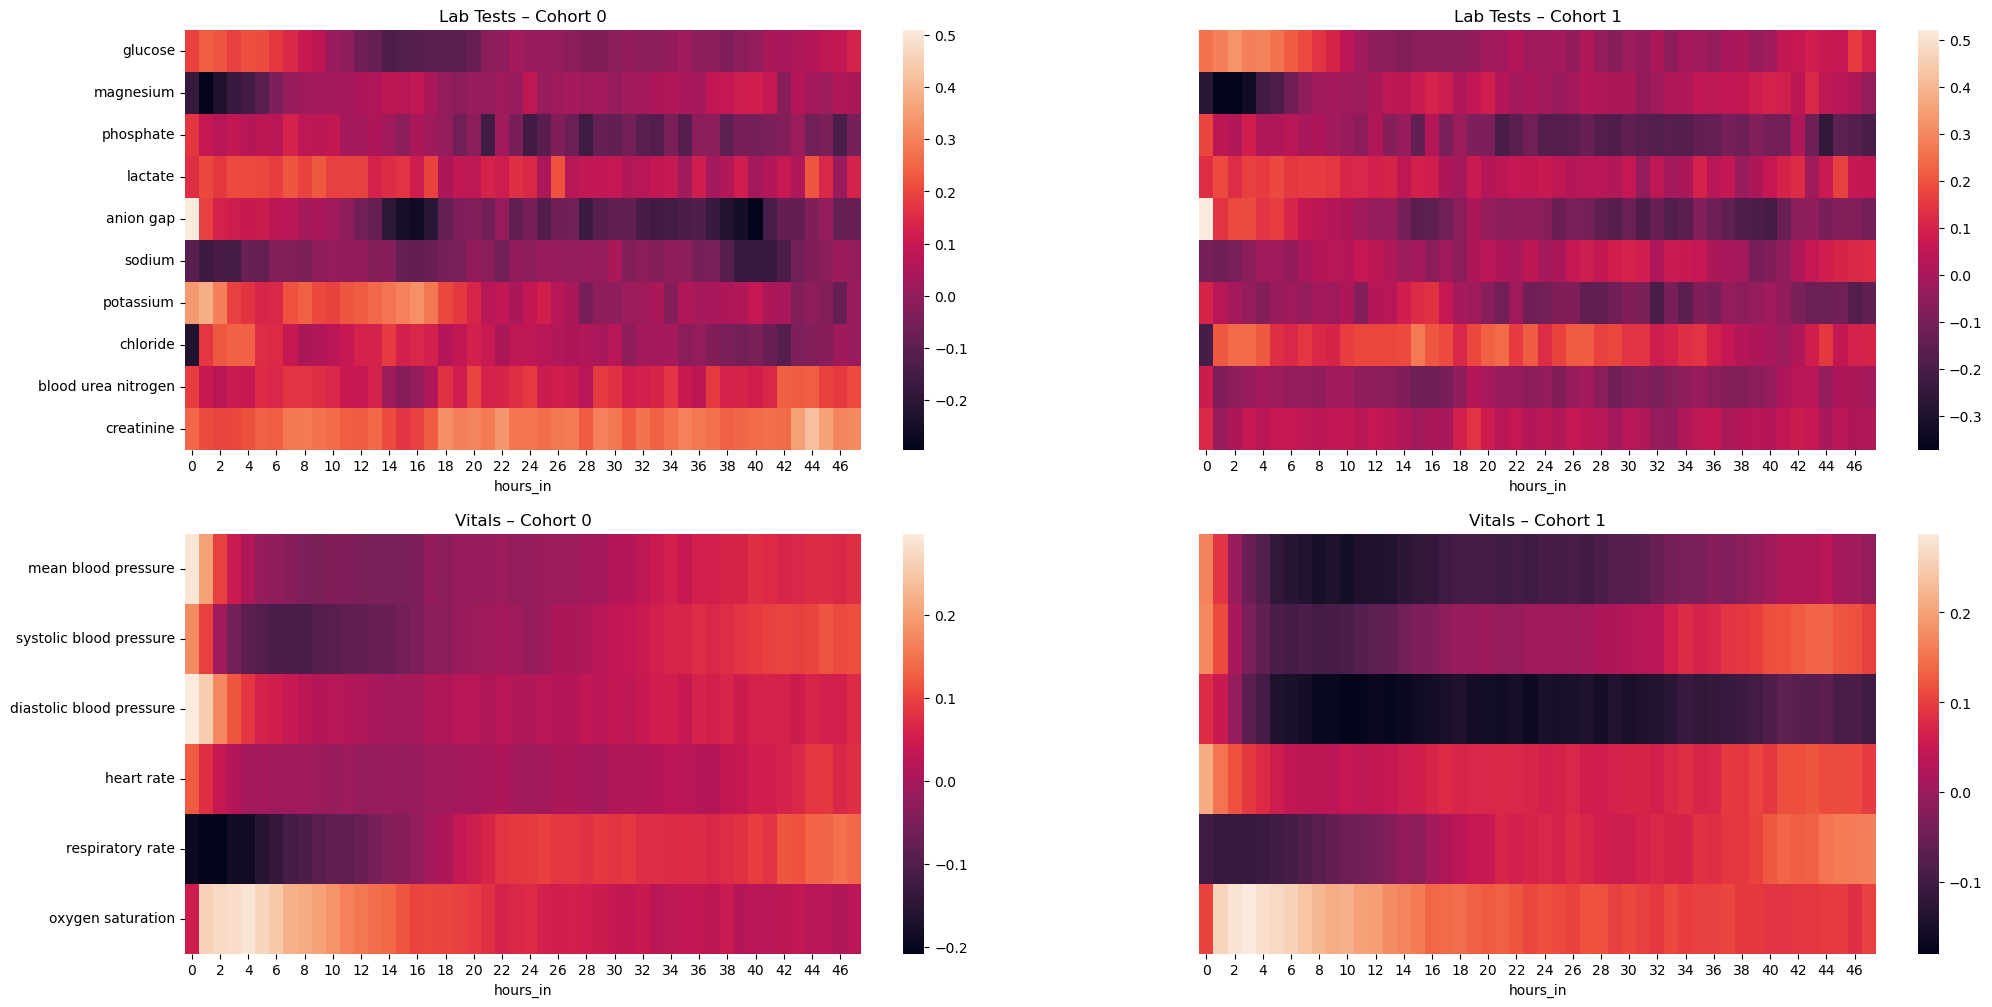

In [24]:
num_cohorts = len(np.unique(labs_df.index.get_level_values(0)))
fig, axs = plt.subplots(nrows=2, ncols=num_cohorts)
fig.set_size_inches(24, 12)
for i in np.arange(num_cohorts):
    plot_df = labs_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[0, i], yticklabels=True if i==0 else False).set(title=f'Lab Tests – Cohort {i}')
for i in np.arange(num_cohorts):
    plot_df = vitals_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[1, i], yticklabels=True if i==0 else False).set(title=f'Vitals – Cohort {i}')
plt.savefig('../img/heatmap_48')

In the 48 hour experiment, labs do not show significant differences between the two cohorts. However, the vitals show changes in the blood pressure where cohort 1 trend is more on the low side compared to cohort 0.

### 2.3. Ablation with embedding size of 50

The original paper uses an embedding size of 100. According to the authors this value was chosen based on the elbow of the reconstruction error curve on the validation set. In this subsection, we will explore results of using an embedding size of 50, half the value suggested by the authors.

#### 2.3.1. Cohort statistics at 24 hours and 48 hours (embedding size of 50)

The paper runs two experiments. The first experiment uses a cutoff period of 24 hours, a gap period of 12 hours, and three clusters. Let's run this first experiment using the `discover_cohorts()` function and determine the corresponding cohort assignment for every patient that does not meet the exception criteria. LSTM autoencoder was set up to provide an embedding of size 50 (half of the optimal value recommended by the authors).

In [25]:
%%time
cohort_unsupervised_24_emb50 = discover_cohorts(cutoff_hours=24, gap_hours=12, num_clusters=3, embedding_dim=50, cohort_unsupervised_filename='../data/unsupervised_clusters_24_emb50.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!
+

The second experiment uses a cutoff period of 48 hours, a gap period of 24 hours, and two instead of three clusters. The reduction in the number of clusters is proposed by the authors (Table 3 of the paper). Let's run now this second experiment using the `discover_cohorts()` function and determine the corresponding cohort assignment for every patient that does not meet the exception criteria. LSTM autoencoder was set up to provide an embedding of size 50 (half of the optimal value recommended by the authors).

In [26]:
%%time
cohort_unsupervised_48_emb50 = discover_cohorts(cutoff_hours=48, gap_hours=24, num_clusters=2, embedding_dim=50, cohort_unsupervised_filename='../data/unsupervised_clusters_48_emb50.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!
+

Let's summarize the results of the 24 hour and 48 hour experiments similar to what Table 3 of the paper shows.

In [27]:
#----------------------------------------------------
# Let's create the summary for the 24 hour experiment

cohort_unsupervised_24_emb50 = np.load('../data/unsupervised_clusters_24_emb50.npy')

from mtl_patients import prepare_data
_, Y, _, _, subject_ids = prepare_data(cutoff_hours=24, gap_hours=12)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!


In [28]:
subject_ids = np.array(subject_ids.tolist())
cohort_unsupervised_24_emb50_df = pd.DataFrame({'subject_id': subject_ids, 'Y': Y, 'Group': cohort_unsupervised_24_emb50}, dtype=int)

# calculate summaries per cohort (24 hours)
table3_a_df = cohort_unsupervised_24_emb50_df.groupby('Group').agg(
    N=('Y', 'size'),
    n=('Y', 'sum'),
)
table3_a_df.loc[:, 'Experiment'] = '24 hours'
table3_a_df.loc[:, 'Cohort Type'] = 'Unsupervised'

# calculate overall summary (24 hours)
table3_a_overall_df = table3_a_df.groupby(['*'] * len(table3_a_df)).agg(
    N=('N', 'sum'),
    n=('n', 'sum'),
)
table3_a_overall_df.index.name = 'Group'
table3_a_overall_df.loc[:, 'Experiment'] = '24 hours'
table3_a_overall_df.loc[:, 'Cohort Type'] = 'Global'

# merge 24 hour tables and make cosmetic changes
table3_a_df = pd.concat([table3_a_df, table3_a_overall_df], axis=0)
table3_a_df.reset_index(inplace=True)
table3_a_df.set_index(['Experiment', 'Cohort Type', 'Group'], inplace=True)

In [29]:
#----------------------------------------------------
# Let's create the summary for the 48 hour experiment

cohort_unsupervised_48_emb50 = np.load('../data/unsupervised_clusters_48_emb50.npy')

_, Y, _, _, subject_ids = prepare_data(cutoff_hours=48, gap_hours=24)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!


In [30]:
subject_ids = np.array(subject_ids.tolist())
cohort_unsupervised_48_emb50_df = pd.DataFrame({'subject_id': subject_ids, 'Y': Y, 'Group': cohort_unsupervised_48_emb50}, dtype=int)

# calculate summaries per cohort (48 hours)
table3_b_df = cohort_unsupervised_48_emb50_df.groupby('Group').agg(
    N=('Y', 'size'),
    n=('Y', 'sum'),
)
table3_b_df.loc[:, 'Experiment'] = '48 hours'
table3_b_df.loc[:, 'Cohort Type'] = 'Unsupervised'

# calculate overall summary (48 hours)
table3_b_overall_df = table3_b_df.groupby(['*'] * len(table3_b_df)).agg(
    N=('N', 'sum'),
    n=('n', 'sum'),
)
table3_b_overall_df.index.name = 'Group'
table3_b_overall_df.loc[:, 'Experiment'] = '48 hours'
table3_b_overall_df.loc[:, 'Cohort Type'] = 'Global'

# merge 48 hour tables and make cosmetic changes
table3_b_df = pd.concat([table3_b_df, table3_b_overall_df], axis=0)
table3_b_df.reset_index(inplace=True)
table3_b_df.set_index(['Experiment', 'Cohort Type', 'Group'], inplace=True)

In [31]:
#--------------------------------------------------------------------
# Now let's merge results for 24 and 48 hour experiments in one table

# merge 24 hour and 48 hour tables
table3_emb50_df = pd.concat([table3_a_df, table3_b_df], axis=0)

# calculate class imbalance
table3_emb50_df.loc[:, 'Class Imbalance'] = table3_df.loc[:, 'n'] / table3_df.loc[:, 'N']
table3_emb50_df.loc[:, 'Class Imbalance'] = table3_df.loc[:, 'Class Imbalance'].round(4)

In [32]:
table3_emb50_df

N     n  Class Imbalance
Experiment Cohort Type  Group                              
24 hours   Unsupervised 0       4087   347           0.0524
                        1      18593  1249           0.0953
                        2      10033   725           0.0513
           Global       *      32713  2321           0.0710
48 hours   Unsupervised 0      13092   574           0.0535
                        1      17350  1165           0.0619
           Global       *      30442  1739           0.0571

Table above is the equivalent to Table 3 in the paper. We can see the results are different. Data from MIMIC-Extract might be different from the data used by the authors.

#### 2.3.2. Visualization of selected lab test and vital signs features (embedding size of 50)

In this section, we will try to reproduce the results from Figure 4 (section 6.1.1) in the paper. In Figure 4, data from experiment 1 (24 hours) is used to create heatmap plots to determine if patients from different cohorts are physiologically distinct. To do that, we added the function `get_heatmap_data()` to get the mean of all z-scores by patient, by hour in the ICU, by cohort. LSTM autoencoder was set up to provide an embedding of size 50 which is half of the optimal value recommended by the authors (ablation).

##### 2.3.2.1. Heatmap plots for experiment 1 (24 hours)

Let's run the `get_heatmap_data()` function using the cohorts discovered in experiment 1 (24 hour cutoff period and 12 hour gap period):

In [33]:
%%time

from mtl_patients import get_heatmap_data
import seaborn as sns
import matplotlib.pyplot as plt

labs_df, vitals_df = get_heatmap_data(cutoff_hours=24, gap_hours=12,
                                      cohort_unsupervised_filename='../data/unsupervised_clusters_24_emb50.npy')

CPU times: user 2.81 s, sys: 1.27 s, total: 4.09 s
Wall time: 3.73 s


Let's plot the heatmaps for the selected lab tests and vitals:

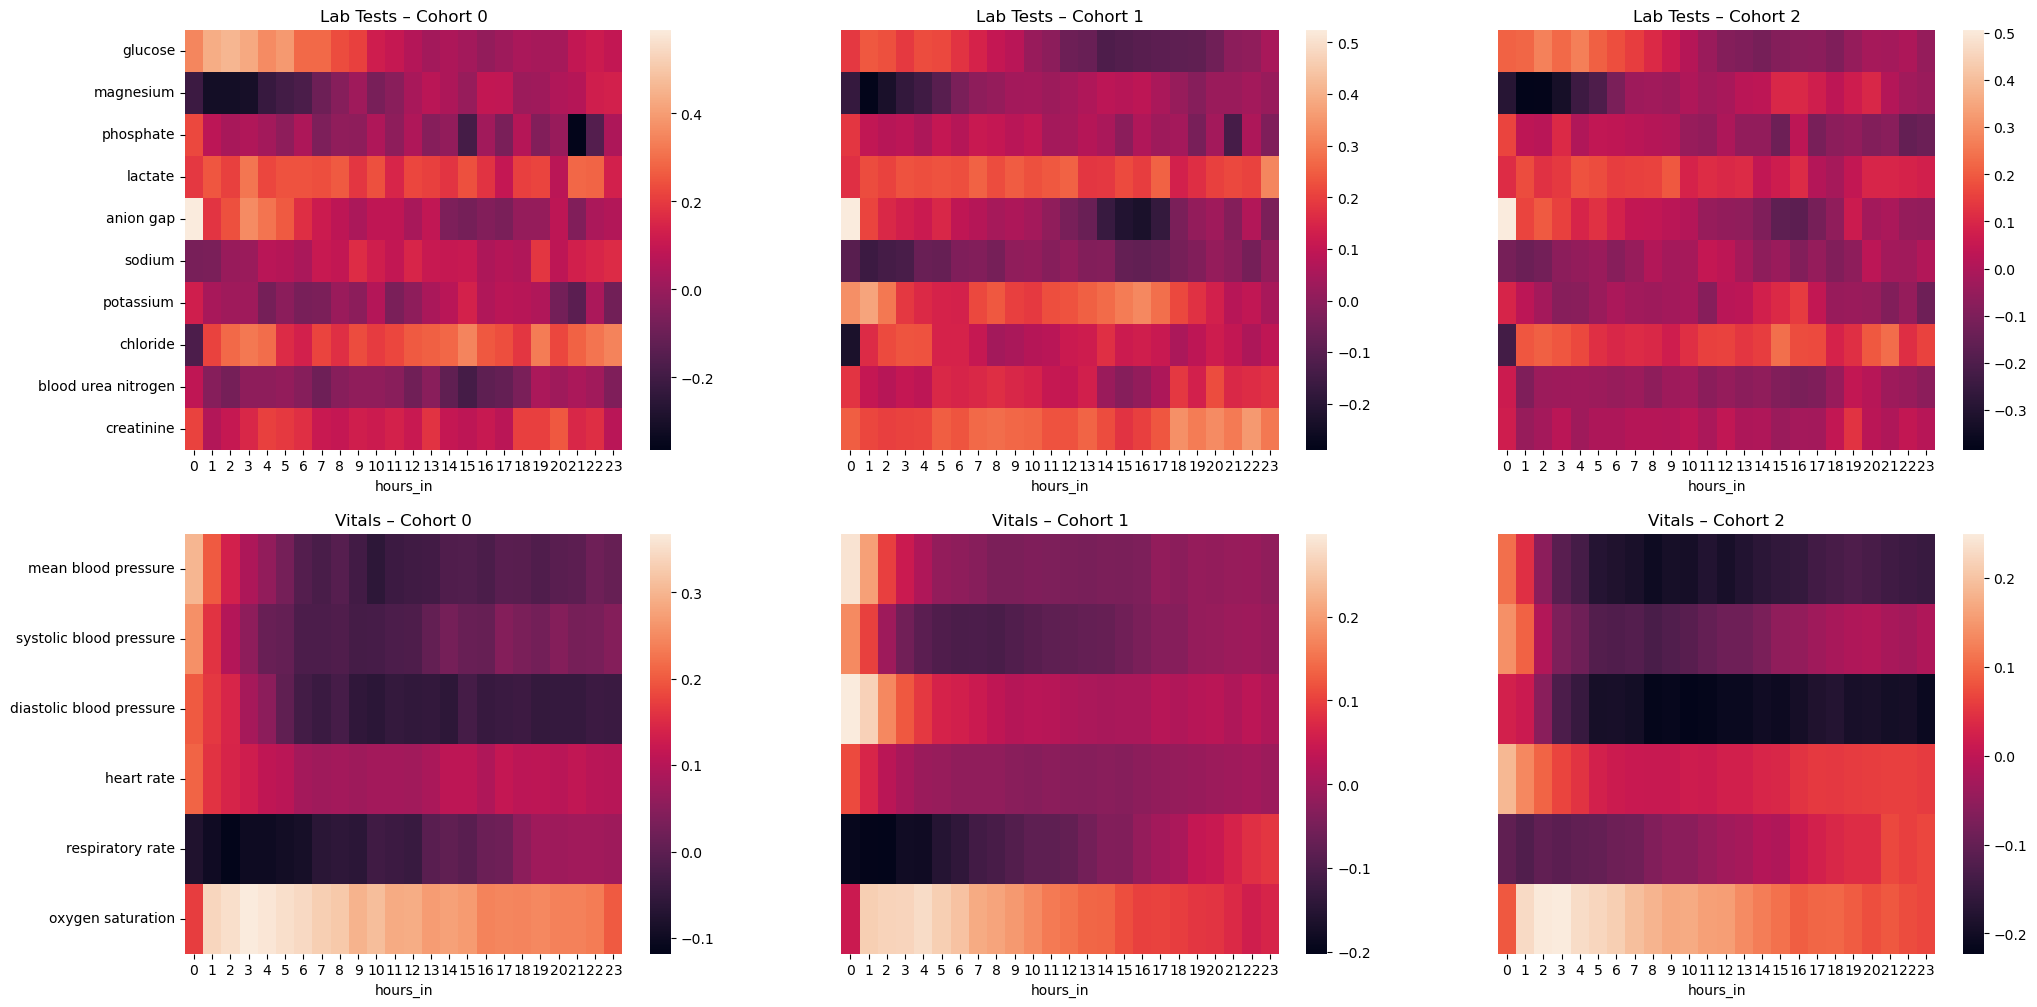

In [34]:
num_cohorts = len(np.unique(labs_df.index.get_level_values(0)))
fig, axs = plt.subplots(nrows=2, ncols=num_cohorts)
fig.set_size_inches(24, 12)
for i in np.arange(num_cohorts):
    plot_df = labs_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[0, i], yticklabels=True if i==0 else False).set(title=f'Lab Tests – Cohort {i}')
for i in np.arange(num_cohorts):
    plot_df = vitals_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[1, i], yticklabels=True if i==0 else False).set(title=f'Vitals – Cohort {i}')
plt.savefig('../img/heatmap_24_emb50')

From the heatmap plots there are some trends in the physiological data that seems to show a distinction between cohorts. In case of labs glucose and blood area nitrogen seems to be different between the three cohorts. However, some of the vitals definitely show different trends in some cases. Blood pressure across the different cohorts is different. When cohort 0 patients have a diastolic blood pressure that tends to drop the longer the patient stays, patients from cohort 2 have a diastolic blood pressure that tends to increase. 

##### 2.3.2.2. Heatmap plots for experiment 2 (48 hours)

Let's run the `get_heatmap_data()` function using the cohorts discovered in experiment 2 (48 hour cutoff period and 24 hour gap period):

In [35]:
%%time
labs_df, vitals_df = get_heatmap_data(cutoff_hours=48, gap_hours=24,
                                      cohort_unsupervised_filename='../data/unsupervised_clusters_48_emb50.npy')

CPU times: user 2.84 s, sys: 983 ms, total: 3.83 s
Wall time: 3.53 s


Let's plot the heatmaps for the selected lab tests and vitals:

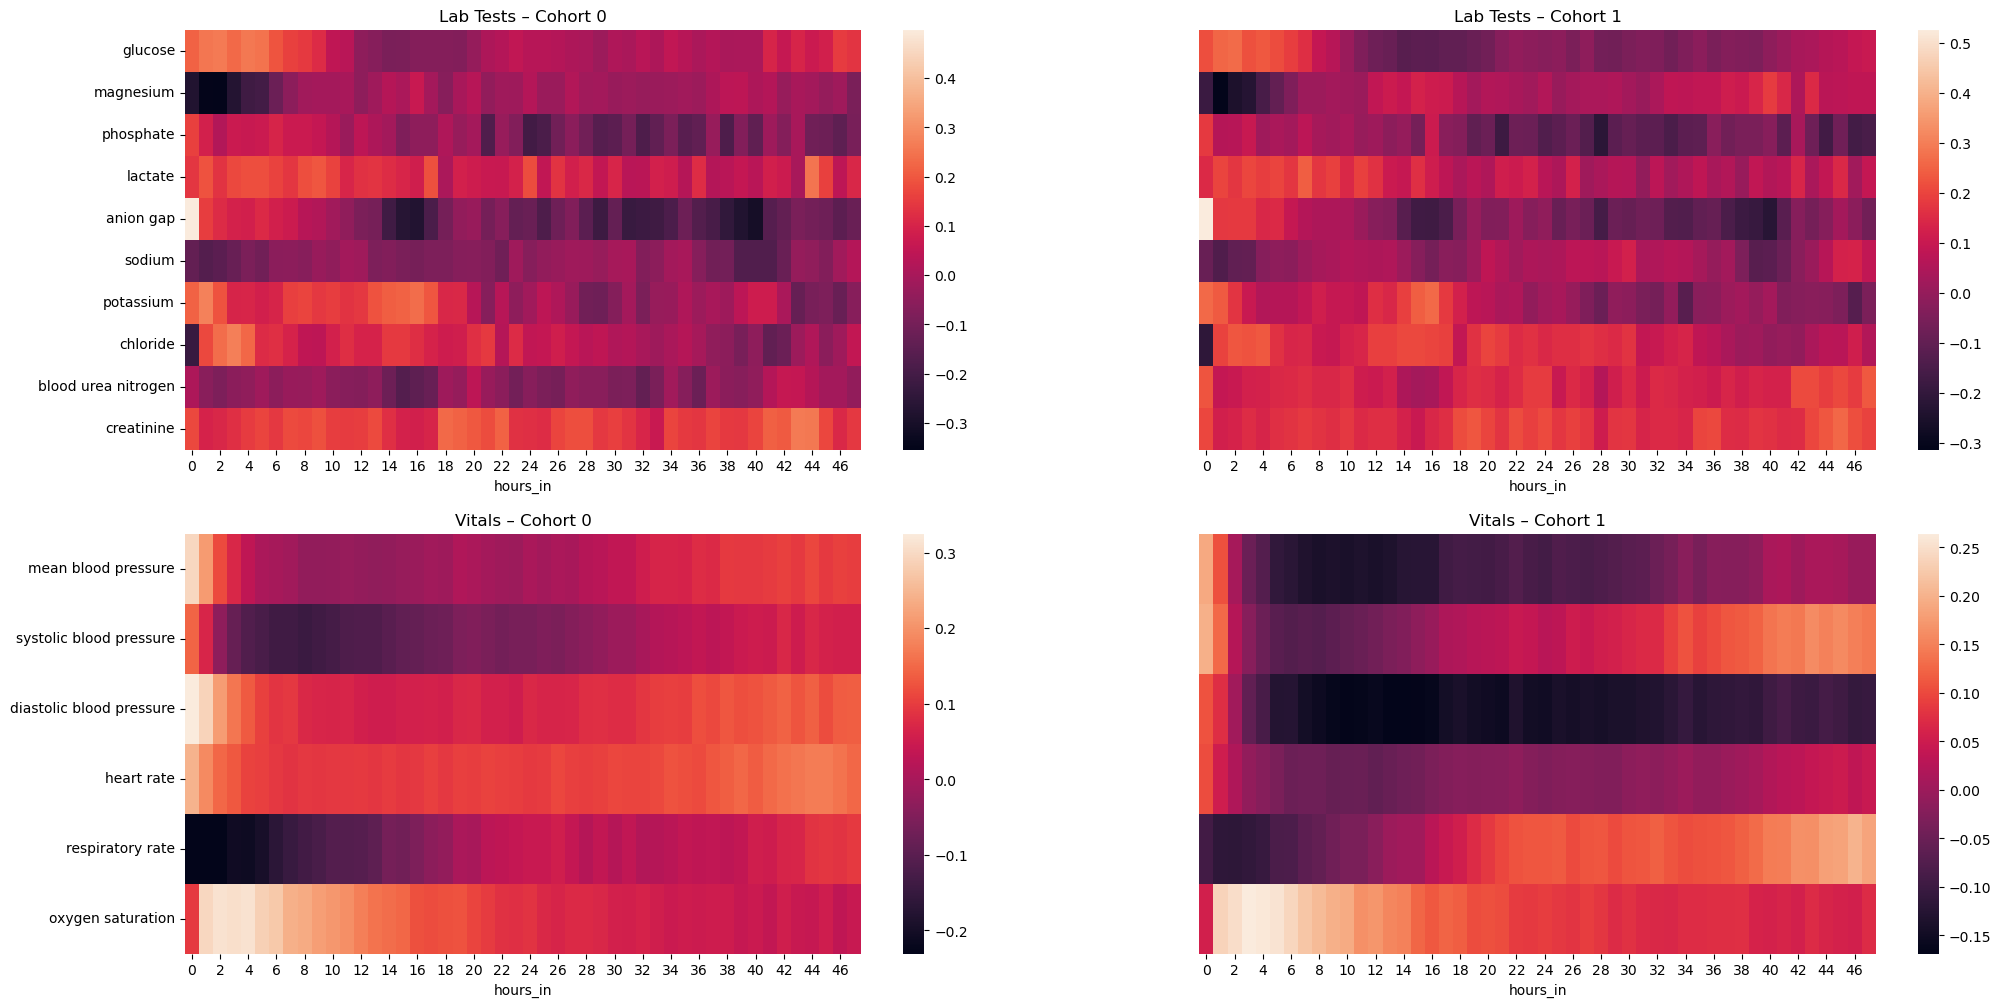

In [36]:
num_cohorts = len(np.unique(labs_df.index.get_level_values(0)))
fig, axs = plt.subplots(nrows=2, ncols=num_cohorts)
fig.set_size_inches(24, 12)
for i in np.arange(num_cohorts):
    plot_df = labs_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[0, i], yticklabels=True if i==0 else False).set(title=f'Lab Tests – Cohort {i}')
for i in np.arange(num_cohorts):
    plot_df = vitals_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[1, i], yticklabels=True if i==0 else False).set(title=f'Vitals – Cohort {i}')
plt.savefig('../img/heatmap_48_emb50')

In the 48 hour experiment, labs do not show significant differences between the two cohorts. However, the vitals show changes in the blood pressure where cohort 1 trend is more on the high side compared to cohort 0.

## 3. <a id='section3'>Predicting In-Hospital Mortality

As mentioned in the previous section, the paper uses a two-step pipeline to: 1) identify relevant patient cohorts, and 2) use those relevant cohorts as separate tasks in a multi-lask learning framework to predict in-hospital mortality. In this section, we will focus on the second step of the pipeline, i.e., use multi-task learning to make in-hospital mortality predictions for different patient cohorts.

The second step uses as input the result from the first step which is a series of 3D matrices, one per discovered cohort, of shape $(P \times T \times F)$ where $P$ represents the number of patients, $T$ the number of timesteps, and $F$ the number of features. As an example, the 24 hour experiment described by the authors in the paper and reproduced in the previous section resulted in three cohorts (clusters) called group 0, group 1, and group 2 where the shapes of the corresponding 3D matrices are:
* $14120 \times 24 \times 232$ for group 0,
* $10841 \times 24 \times 232$ for group 1, and
* $7752 \times 24 \times 232$ for group 2.

To convert these matrices into predictions, the paper proposes an LSTM for all model configurations including the baseline. In particular, the paper shows results from two specific models: a baseline model that is called *global* and using single-task learning and the multi-task learning model the authors claim as superior to the baseline.

A diagram of the baseline (*global*) model proposed by the authors is shown below. As it can be seen, this model consists of an LSTM layer of 16 cells using a RELU activation function followed by a *single* dense layer with a sigmoid activation function. The result of the dense (fully-connected) layer is an estimate of the probability of in-hospital mortality for a given patient. This baseline model is trained with all patient samples regardless the cohort, hence the name *global*, and used for per cohort predictions.

![Figure 2](../img/paper-181-fig-2.png)

Moving to the second model and the one the authors claim it provides benefits against the baseline is the so called *multi-task learning model*. This model consists of an LSTM layer with same number of cells (16) as the baseline model, to ensure the comparison is fair, connected to as many dense layers as population subgroups (cohorts). Each of these cohorts is considered a *task* and authors propose training these models on multiple tasks simultaneously in contrast to the baseline model with just one dense layer. The benefit of this approach according to the authors is the ability to share knowledge learned from one task (cohort) to rest of tasks under the assumption that the subpopulations used are distinct enough with relation to the outcome learned (mortality) that such shared knowledge truly exists. A representation of the multi-task learning model is shown below:

![Figure 3](../img/paper-181-fig-3.png)

For benchmarking purposes of the entire pipeline, the authors compared the results from running the pipeline using unsupervised cohort discovery (step one) against cohorts created using the first careunit the patient went into which can be considered an engineered feature. We will show those results in the next subsections.

The overall performance of this model is measured using both macro and micro metrics (section 4.3 in the paper) where:
* In *micro* metrics all predicted probabilities for all patients are treated as if they come from a single classifier: $\text{Metric}_\text{Micro} = \text{Metric}([\hat{y}_0, ..., \hat{y}_k], [y_0, ..., y_K])$.
* In *macro* metrics probabilities are evaluated on a *per cohort* basis, and then averaged: $\text{Metric}_\text{Macro} = \dfrac{1}{K} \displaystyle\sum_{k=0}^K \text{Metric}(\hat{y}_K, y_K)$.

Paper suggests that, although micro metrics are the ones typically chosen in the literature, evaluating performance on different subpopulations will benefit from macro metrics instead of micro metrics specially when there is class imbalance in every cohort. All results show macro and micro versions of the metrics for the aggregate performance of the models.

All results being used for comparison between models by the paper will use three metrics:
* AUC (Area Under the ROC Curve) for every cohort and, for the aggregate performance, macro and micro.
* PPV (Positive Predictive Value which is same as Precision) for every cohort and, for the aggregate performance, macro and micro. This PPV is calculated at a sensitivity of 80%, a value selected by the paper authors.
* Specificity for every cohort and, for the aggregate performance, macro and micro. This specificity is calculated at a sensitivity of 80%, a value selected by the paper authors.

All in-hospital mortality prediction tasks are implemented using the function `run_mortality_prediction_task()`. This function will call other functions to prepare the data, split the data in training/validation/test data sets, train the corresponding model, predict using the resulting model, and calculate the metrics of the model.

### 3.1. Predictions without Bootstrapping

In this section all in-hospital mortality predictions across the two models, global and multi-task learning, and across the two experiments, 24 hours and 48 hours, are calculated for the three metrics; AUC, PPV (precision) @80% sensitivity, and Specificity @80% sensitivity; using the test set (20% of the original dataset). No bootstrapping is done.

#### 3.1.1. In-Hospital Mortality Prediction – Baseline (*Global*) Model at 24 Hours

Let's first run the mortality prediction task using the *global* model (baseline) in the 24 hour experiment setting. In this experiment, the cutoff period is 24 hours and the gap period is 12 hours, meaning model can only feed from patient data collected during the first 24 hours of the ICU stay, and predict mortality 36 hours after patient goes into the ICU to avoid label leakage. In terms of the cohort type, let's go with careunits first:

In [37]:
%%time

from mtl_patients import run_mortality_prediction_task

metrics_global_24_careunits_df = run_mortality_prediction_task(model_type='global', cutoff_hours=24, gap_hours=12, cohort_criteria_to_select='careunits')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!
+

In [38]:
metrics_global_24_careunits_df.round(3)

,AUC,PPV,Specificity
CCU,0.867,0.222,0.812
CSRU,0.890,0.101,0.873
MICU,0.829,0.225,0.675
SICU,0.853,0.201,0.736
TSICU,0.866,0.216,0.798
Macro,0.861,0.193,0.779
Micro,0.864,0.203,0.760


Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [39]:
%%time
metrics_global_24_unsupervised_df = run_mortality_prediction_task(model_type='global', cutoff_hours=24, gap_hours=12,
                                                                  cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_24.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!
+

In [40]:
metrics_global_24_unsupervised_df.round(3)

,AUC,PPV,Specificity
0,0.873,0.209,0.807
1,0.830,0.219,0.706
2,0.895,0.166,0.803
Macro,0.866,0.198,0.772
Micro,0.864,0.203,0.760


#### 3.1.2. In-Hospital Mortality Prediction – Baseline (*Global*) Model at 48 Hours

Let's now run the mortality prediction task using the *global* model (baseline) in the 48 hour experiment setting. In this experiment, the cutoff period is 48 hours and the gap period is 24 hours, meaning model can only feed from patient data collected during the first 48 hours of the ICU stay, and predict mortality 72 hours after patient goes into the ICU to avoid label leakage. In terms of the cohort type, let's go with careunits first:

In [41]:
%%time
metrics_global_48_careunits_df = run_mortality_prediction_task(model_type='global', cutoff_hours=48, gap_hours=24, cohort_criteria_to_select='careunits')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!
+

In [42]:
metrics_global_48_careunits_df.round(3)

,AUC,PPV,Specificity
CCU,0.839,0.181,0.763
CSRU,0.928,0.067,0.863
MICU,0.825,0.185,0.685
SICU,0.858,0.207,0.797
TSICU,0.804,0.110,0.651
Macro,0.851,0.150,0.752
Micro,0.854,0.155,0.736


Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [43]:
%%time
metrics_global_48_unsupervised_df = run_mortality_prediction_task(model_type='global', cutoff_hours=48, gap_hours=24,
                                                                  cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_48.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!
+

In [44]:
metrics_global_48_unsupervised_df.round(3)

,AUC,PPV,Specificity
0,0.848,0.143,0.727
1,0.863,0.186,0.774
Macro,0.855,0.164,0.751
Micro,0.854,0.155,0.736


#### 3.1.3. In-Hospital Mortality Prediction – Multi-Task Learning Model at 24 Hours

Let's now run the mortality prediction task using the multi-task learning model in the 24 hour experiment setting. In this experiment, the cutoff period is 24 hours and the gap period is 12 hours, meaning model can only feed from patient data collected during the first 24 hours of the ICU stay, and predict mortality 36 hours after patient goes into the ICU to avoid label leakage. In terms of the cohort type, let's go with careunits first:

In [45]:
%%time
metrics_mtl_24_careunits_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=24, gap_hours=12, cohort_criteria_to_select='careunits')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!
+

In [46]:
metrics_mtl_24_careunits_df.round(3)

,AUC,PPV,Specificity
CCU,0.859,0.194,0.779
CSRU,0.903,0.080,0.835
MICU,0.832,0.244,0.708
SICU,0.840,0.193,0.722
TSICU,0.870,0.184,0.753
Macro,0.861,0.179,0.759
Micro,0.865,0.220,0.785


Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [47]:
%%time
metrics_mtl_24_unsupervised_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=24, gap_hours=12,
                                                               cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_24.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!
+

In [48]:
metrics_mtl_24_unsupervised_df.round(3)

,AUC,PPV,Specificity
0,0.859,0.176,0.757
1,0.833,0.227,0.719
2,0.901,0.192,0.835
Macro,0.864,0.198,0.770
Micro,0.864,0.210,0.772


#### 3.1.4. In-Hospital Mortality Prediction – Multi-Task Learning Model at 48 Hours

Let's now run the mortality prediction task using the multi-task learning model in the 48 hour experiment setting. In this experiment, the cutoff period is 48 hours and the gap period is 24 hours, meaning model can only feed from patient data collected during the first 48 hours of the ICU stay, and predict mortality 72 hours after patient goes into the ICU to avoid label leakage. In terms of the cohort type, let's go with careunits first:

In [49]:
%%time
metrics_mtl_48_careunits_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=48, gap_hours=24, cohort_criteria_to_select='careunits')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!
+

In [50]:
metrics_mtl_48_careunits_df.round(3)

,AUC,PPV,Specificity
CCU,0.844,0.162,0.728
CSRU,0.909,0.081,0.889
MICU,0.827,0.196,0.707
SICU,0.867,0.240,0.835
TSICU,0.834,0.145,0.746
Macro,0.856,0.165,0.781
Micro,0.862,0.174,0.771


Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [51]:
%%time
metrics_mtl_48_unsupervised_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=48, gap_hours=24,
                                                               cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_48.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!
+

In [52]:
metrics_mtl_48_unsupervised_df.round(3)

,AUC,PPV,Specificity
0,0.850,0.156,0.753
1,0.871,0.198,0.792
Macro,0.861,0.177,0.773
Micro,0.859,0.169,0.763


#### 3.1.5. Summary

Similar to Table 4 in paper, the dataframe below summarizes all results.

In [53]:
summary_a_df = metrics_global_24_unsupervised_df.reset_index()
summary_a_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_a_df['Cohort type'] = 'Unsupervised'
summary_a_df['Model'] = 'Global'
summary_a_df['Experiment'] = '24 hours'

summary_b_df = metrics_global_24_careunits_df.reset_index()
summary_b_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_b_df['Cohort type'] = 'Careunits'
summary_b_df['Model'] = 'Global'
summary_b_df['Experiment'] = '24 hours'

summary_c_df = metrics_mtl_24_unsupervised_df.reset_index()
summary_c_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_c_df['Cohort type'] = 'Unsupervised'
summary_c_df['Model'] = 'Multi-task'
summary_c_df['Experiment'] = '24 hours'

summary_d_df = metrics_mtl_24_careunits_df.reset_index()
summary_d_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_d_df['Cohort type'] = 'Careunits'
summary_d_df['Model'] = 'Multi-task'
summary_d_df['Experiment'] = '24 hours'

summary_24_df = pd.concat([summary_a_df, summary_b_df, summary_c_df, summary_d_df])

summary_e_df = metrics_global_48_unsupervised_df.reset_index()
summary_e_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_e_df['Cohort type'] = 'Unsupervised'
summary_e_df['Model'] = 'Global'
summary_e_df['Experiment'] = '48 hours'

summary_f_df = metrics_global_48_careunits_df.reset_index()
summary_f_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_f_df['Cohort type'] = 'Careunits'
summary_f_df['Model'] = 'Global'
summary_f_df['Experiment'] = '48 hours'

summary_g_df = metrics_mtl_48_unsupervised_df.reset_index()
summary_g_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_g_df['Cohort type'] = 'Unsupervised'
summary_g_df['Model'] = 'Multi-task'
summary_g_df['Experiment'] = '48 hours'

summary_h_df = metrics_mtl_48_careunits_df.reset_index()
summary_h_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_h_df['Cohort type'] = 'Careunits'
summary_h_df['Model'] = 'Multi-task'
summary_h_df['Experiment'] = '48 hours'

summary_48_df = pd.concat([summary_e_df, summary_f_df, summary_g_df, summary_h_df])

summary_df = pd.concat([summary_24_df, summary_48_df])

# This is a trick using a categorical data type to have Macro and Micro after Cohort names while displaying
from pandas.api.types import CategoricalDtype
cohort = CategoricalDtype(['0', '1', '2', 'CCU', 'CSRU', 'MICU', 'SICU', 'TSICU', 'Macro', 'Micro'], ordered=True)
summary_df['Cohort'] = summary_df['Cohort'].astype(cohort)

summary_df = pd.melt(summary_df, id_vars=['Cohort', 'Cohort type', 'Model', 'Experiment'], var_name='Metric')
summary_df = summary_df.set_index(['Experiment', 'Cohort type', 'Cohort'])
summary_df = summary_df.pivot(columns=['Metric', 'Model'], values='value')
summary_df = summary_df.round(3)
summary_df

Metric                            AUC               PPV             \
Model                          Global Multi-task Global Multi-task   
Experiment Cohort type  Cohort                                       
24 hours   Careunits    CCU     0.867      0.859  0.222      0.194   
                        CSRU    0.890      0.903  0.101      0.080   
                        MICU    0.829      0.832  0.225      0.244   
                        SICU    0.853      0.840  0.201      0.193   
                        TSICU   0.866      0.870  0.216      0.184   
                        Macro   0.861      0.861  0.193      0.179   
                        Micro   0.864      0.865  0.203      0.220   
           Unsupervised 0       0.873      0.859  0.209      0.176   
                        1       0.830      0.833  0.219      0.227   
                        2       0.895      0.901  0.166      0.192   
                        Macro   0.866      0.864  0.198      0.198   
                        Micro   0.864      0.864  0.203      0.210   
48 hours   Careunits    CCU     0.839      0.844  0.181      0.162   
                        CSRU    0.928      0.909  0.067      0.081   
                        MICU    0.825      0.827  0.185      0.196   
                        SICU    0.858      0.867  0.207      0.240   
                        TSICU   0.804      0.834  0.110      0.145   
                        Macro   0.851      0.856  0.150      0.165   
                        Micro   0.854      0.862  0.155      0.174   
           Unsupervised 0       0.848      0.850  0.143      0.156   
                        1       0.863      0.871  0.186      0.198   
                        Macro   0.855      0.861  0.164      0.177   
                        Micro   0.854      0.859  0.155      0.169   

Metric                         Specificity             
Model                               Global Multi-task  
Experiment Cohort type  Cohort                         
24 hours   Careunits    CCU          0.812      0.779  
                        CSRU         0.873      0.835  
                        MICU         0.675      0.708  
                        SICU         0.736      0.722  
                        TSICU        0.798      0.753  
                        Macro        0.779      0.759  
                        Micro        0.760      0.785  
           Unsupervised 0            0.807      0.757  
                        1            0.706      0.719  
                        2            0.803      0.835  
                        Macro        0.772      0.770  
                        Micro        0.760      0.772  
48 hours   Careunits    CCU          0.763      0.728  
                        CSRU         0.863      0.889  
                        MICU         0.685      0.707  
                        SICU         0.797      0.835  
                        TSICU        0.651      0.746  
                        Macro        0.752      0.781  
                        Micro        0.736      0.771  
           Unsupervised 0            0.727      0.753  
                        1            0.774      0.792  
                        Macro        0.751      0.773  
                        Micro        0.736      0.763

### 3.2. Predictions with Bootstrapping

In this section all in-hospital mortality predictions across the two models, global and multi-task learning, and across the two experiments, 24 hours and 48 hours, are calculated for the three metrics; AUC, PPV (precision) @80% sensitivity, and Specificity @80% sensitivity; using 100 bootstrapped samples of the test set (20% of the original dataset). The results will be metrics (AUC, PPV, and Specificity) for each bootstrapped sample. This will allow the comparison between the global model and the multi-task learning model using the Wilcoxon signed-rank test as indicated in the paper.

#### 3.2.1. In-Hospital Mortality Prediction – Baseline (*Global*) Model at 24 Hours

Let's first run the mortality prediction task using the *global* model (baseline) in the 24 hour experiment setting. In this experiment, the cutoff period is 24 hours and the gap period is 12 hours, meaning model can only feed from patient data collected during the first 24 hours of the ICU stay, and predict mortality 36 hours after patient goes into the ICU to avoid label leakage. Since we are enabling bootstrapping, we will repeat same experiment with 100 bootstrapped samples from the test dataset. In terms of the cohort type, let's go with careunits first:

In [54]:
%%time

from mtl_patients import run_mortality_prediction_task

metrics_global_24_careunits_btstrp_df = run_mortality_prediction_task(model_type='global', cutoff_hours=24, gap_hours=12, cohort_criteria_to_select='careunits', bootstrap=True)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!
+

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "CSRU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "MICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "SICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "TSICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 3min 22s, sys: 11.7 s, total: 3min 34s
Wall time: 3min 25s


In [55]:
pd.options.display.max_rows = 20
metrics_global_24_careunits_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
CCU    1       0.857  0.261        0.851
       2       0.892  0.183        0.843
       3       0.870  0.236        0.853
       4       0.889  0.207        0.831
       5       0.836  0.121        0.688
...              ...    ...          ...
Macro  96      0.866  0.215        0.790
       97      0.846  0.184        0.741
       98      0.891  0.242        0.833
       99      0.850  0.181        0.750
       100     0.882  0.206        0.805

[700 rows x 3 columns]

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [56]:
%%time
metrics_global_24_unsupervised_btstrp_df = run_mortality_prediction_task(model_type='global', cutoff_hours=24, gap_hours=12, bootstrap=True,
                                                                         cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_24.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!
+

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "1"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "2"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 3min 8s, sys: 11.5 s, total: 3min 20s
Wall time: 3min 11s


In [57]:
metrics_global_24_unsupervised_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
0      1       0.900  0.220        0.824
       2       0.849  0.174        0.772
       3       0.874  0.215        0.809
       4       0.885  0.243        0.834
       5       0.883  0.212        0.787
...              ...    ...          ...
Macro  96      0.881  0.237        0.811
       97      0.870  0.193        0.762
       98      0.887  0.240        0.798
       99      0.860  0.165        0.716
       100     0.871  0.193        0.761

[500 rows x 3 columns]

#### 3.2.2. In-Hospital Mortality Prediction – Baseline (*Global*) Model at 48 Hours

Let's first run the mortality prediction task using the *global* model (baseline) in the 48 hour experiment setting. In this experiment, the cutoff period is 48 hours and the gap period is 24 hours, meaning model can only feed from patient data collected during the first 48 hours of the ICU stay, and predict mortality 72 hours after patient goes into the ICU to avoid label leakage. Since we are enabling bootstrapping, we will repeat same experiment with 100 bootstrapped samples from the test dataset. In terms of the cohort type, let's go with careunits first:

In [58]:
%%time

from mtl_patients import run_mortality_prediction_task

metrics_global_48_careunits_btstrp_df = run_mortality_prediction_task(model_type='global', cutoff_hours=48, gap_hours=24, cohort_criteria_to_select='careunits', bootstrap=True)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!
+

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "CSRU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "MICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "SICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "TSICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 6min 17s, sys: 1min 47s, total: 8min 4s
Wall time: 7min 54s


In [59]:
metrics_global_48_careunits_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
CCU    1       0.840  0.185        0.746
       2       0.840  0.238        0.815
       3       0.827  0.148        0.679
       4       0.836  0.128        0.670
       5       0.810  0.113        0.633
...              ...    ...          ...
Macro  96      0.859  0.166        0.765
       97      0.851  0.155        0.750
       98      0.855  0.161        0.775
       99      0.865  0.202        0.803
       100     0.854  0.183        0.764

[700 rows x 3 columns]

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [60]:
%%time
metrics_global_48_unsupervised_btstrp_df = run_mortality_prediction_task(model_type='global', cutoff_hours=48, gap_hours=24, bootstrap=True,
                                                                         cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_48.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!
+

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "1"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 5min 39s, sys: 1min 15s, total: 6min 54s
Wall time: 6min 49s


In [61]:
metrics_global_48_unsupervised_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
0      1       0.841  0.154        0.716
       2       0.844  0.138        0.713
       3       0.847  0.140        0.715
       4       0.851  0.157        0.731
       5       0.842  0.142        0.724
...              ...    ...          ...
Macro  96      0.851  0.168        0.747
       97      0.848  0.162        0.744
       98      0.856  0.166        0.752
       99      0.863  0.166        0.755
       100     0.845  0.153        0.733

[400 rows x 3 columns]

#### 3.2.3. In-Hospital Mortality Prediction – Multi-Task Learning Model at 24 Hours

Let's now run the mortality prediction task using the multi-task learning model in the 24 hour experiment setting. In this experiment, the cutoff period is 24 hours and the gap period is 12 hours, meaning model can only feed from patient data collected during the first 24 hours of the ICU stay, and predict mortality 36 hours after patient goes into the ICU to avoid label leakage. Since we are enabling bootstrapping, we will repeat same experiment with 100 bootstrapped samples from the test dataset. In terms of the cohort type, let's go with careunits first:

In [62]:
%%time

from mtl_patients import run_mortality_prediction_task

metrics_mtl_24_careunits_btstrp_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=24, gap_hours=12, cohort_criteria_to_select='careunits', bootstrap=True)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!
+

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "CSRU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "MICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "SICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "TSICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 3min 47s, sys: 13.3 s, total: 4min 1s
Wall time: 3min 51s


In [63]:
metrics_mtl_24_careunits_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
CCU    1       0.870  0.244        0.840
       2       0.839  0.115        0.730
       3       0.887  0.209        0.824
       4       0.853  0.197        0.812
       5       0.828  0.122        0.684
...              ...    ...          ...
Macro  96      0.862  0.205        0.762
       97      0.848  0.178        0.748
       98      0.886  0.232        0.820
       99      0.855  0.183        0.757
       100     0.885  0.212        0.805

[700 rows x 3 columns]

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [64]:
%%time
metrics_mtl_24_unsupervised_btstrp_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=24, gap_hours=12, bootstrap=True,
                                                                      cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_24.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 232)
    Number of positive samples: 2321
    Done!
+

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "1"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "2"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 3min 16s, sys: 11.1 s, total: 3min 27s
Wall time: 3min 18s


In [65]:
metrics_mtl_24_unsupervised_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
0      1       0.882  0.203        0.805
       2       0.835  0.158        0.747
       3       0.864  0.186        0.765
       4       0.883  0.223        0.812
       5       0.868  0.192        0.764
...              ...    ...          ...
Macro  96      0.877  0.250        0.817
       97      0.863  0.175        0.727
       98      0.883  0.259        0.812
       99      0.864  0.175        0.735
       100     0.869  0.189        0.754

[500 rows x 3 columns]

#### 3.2.4. In-Hospital Mortality Prediction – Multi-Task Learning Model at 48 Hours

Let's now run the mortality prediction task using the multi-task learning model in the 48 hour experiment setting. In this experiment, the cutoff period is 48 hours and the gap period is 24 hours, meaning model can only feed from patient data collected during the first 48 hours of the ICU stay, and predict mortality 72 hours after patient goes into the ICU to avoid label leakage. Since we are enabling bootstrapping, we will repeat same experiment with 100 bootstrapped samples from the test dataset. In terms of the cohort type, let's go with careunits first:

In [66]:
%%time

from mtl_patients import run_mortality_prediction_task

metrics_mtl_48_careunits_btstrp_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=48, gap_hours=24, cohort_criteria_to_select='careunits', bootstrap=True)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!
+

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "CSRU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "MICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "SICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "TSICU"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 6min 8s, sys: 1min 48s, total: 7min 57s
Wall time: 7min 47s


In [67]:
metrics_mtl_48_careunits_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
CCU    1       0.845  0.177        0.726
       2       0.850  0.161        0.699
       3       0.834  0.162        0.718
       4       0.837  0.161        0.754
       5       0.790  0.113        0.645
...              ...    ...          ...
Macro  96      0.874  0.199        0.822
       97      0.852  0.209        0.780
       98      0.854  0.161        0.784
       99      0.875  0.196        0.802
       100     0.863  0.185        0.781

[700 rows x 3 columns]

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [68]:
%%time
metrics_mtl_48_unsupervised_btstrp_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=48, gap_hours=24, bootstrap=True,
                                                                      cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_48.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 33), X.subject_id.nunique(): 34472
        X_discrete.shape: (2200954, 225), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 223), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...
    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 232)
    Number of positive samples: 1739
    Done!
+

  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "1"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Bootstrap prediction for task "all"...


  0%|          | 0/100 [00:00<?, ?it/s]

    Done!
CPU times: user 5min 12s, sys: 1min 17s, total: 6min 29s
Wall time: 6min 25s


In [69]:
metrics_mtl_48_unsupervised_btstrp_df.round(3)

AUC    PPV  Specificity
Cohort Sample                           
0      1       0.845  0.179        0.762
       2       0.852  0.156        0.752
       3       0.849  0.148        0.732
       4       0.848  0.180        0.772
       5       0.852  0.152        0.741
...              ...    ...          ...
Macro  96      0.858  0.188        0.783
       97      0.850  0.169        0.754
       98      0.862  0.174        0.766
       99      0.869  0.178        0.781
       100     0.852  0.165        0.756

[400 rows x 3 columns]

#### 3.2.5. Summary

Similar to Table 4 in paper, the dataframe below summarizes all results. Due to bootstrapping we will get 100 metric (AUC, PPV, or Specificity) values for every combination of experiment (24 hours or 48 hours), cohort type (careunits or unsupervised), and model type (global or multi-task. We will reduce that table in a next step.

In [70]:
summary_a_btstrp_df = metrics_global_24_unsupervised_btstrp_df.reset_index()
summary_a_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_a_btstrp_df['Cohort type'] = 'Unsupervised'
summary_a_btstrp_df['Model'] = 'Global'
summary_a_btstrp_df['Experiment'] = '24 hours'

summary_b_btstrp_df = metrics_global_24_careunits_btstrp_df.reset_index()
summary_b_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_b_btstrp_df['Cohort type'] = 'Careunits'
summary_b_btstrp_df['Model'] = 'Global'
summary_b_btstrp_df['Experiment'] = '24 hours'

summary_c_btstrp_df = metrics_mtl_24_unsupervised_btstrp_df.reset_index()
summary_c_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_c_btstrp_df['Cohort type'] = 'Unsupervised'
summary_c_btstrp_df['Model'] = 'Multi-task'
summary_c_btstrp_df['Experiment'] = '24 hours'

summary_d_btstrp_df = metrics_mtl_24_careunits_btstrp_df.reset_index()
summary_d_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_d_btstrp_df['Cohort type'] = 'Careunits'
summary_d_btstrp_df['Model'] = 'Multi-task'
summary_d_btstrp_df['Experiment'] = '24 hours'

summary_24_btstrp_df = pd.concat([summary_a_btstrp_df, summary_b_btstrp_df, summary_c_btstrp_df, summary_d_btstrp_df])

summary_e_btstrp_df = metrics_global_48_unsupervised_btstrp_df.reset_index()
summary_e_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_e_btstrp_df['Cohort type'] = 'Unsupervised'
summary_e_btstrp_df['Model'] = 'Global'
summary_e_btstrp_df['Experiment'] = '48 hours'

summary_f_btstrp_df = metrics_global_48_careunits_btstrp_df.reset_index()
summary_f_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_f_btstrp_df['Cohort type'] = 'Careunits'
summary_f_btstrp_df['Model'] = 'Global'
summary_f_btstrp_df['Experiment'] = '48 hours'

summary_g_btstrp_df = metrics_mtl_48_unsupervised_btstrp_df.reset_index()
summary_g_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_g_btstrp_df['Cohort type'] = 'Unsupervised'
summary_g_btstrp_df['Model'] = 'Multi-task'
summary_g_btstrp_df['Experiment'] = '48 hours'

summary_h_btstrp_df = metrics_mtl_48_careunits_btstrp_df.reset_index()
summary_h_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_h_btstrp_df['Cohort type'] = 'Careunits'
summary_h_btstrp_df['Model'] = 'Multi-task'
summary_h_btstrp_df['Experiment'] = '48 hours'

summary_48_btstrp_df = pd.concat([summary_e_btstrp_df, summary_f_btstrp_df, summary_g_btstrp_df, summary_h_btstrp_df])

summary_btstrp_df = pd.concat([summary_24_btstrp_df, summary_48_btstrp_df])

# This is a trick using a categorical data type to have Macro and Micro after Cohort names while displaying
from pandas.api.types import CategoricalDtype
cohort = CategoricalDtype(['0', '1', '2', 'CCU', 'CSRU', 'MICU', 'SICU', 'TSICU', 'Macro', 'Micro'], ordered=True)
summary_btstrp_df['Cohort'] = summary_btstrp_df['Cohort'].astype(cohort)
summary_btstrp_df = summary_btstrp_df.dropna()

summary_btstrp_df = pd.melt(summary_btstrp_df, id_vars=['Cohort', 'Sample', 'Cohort type', 'Model', 'Experiment'], var_name='Metric')
summary_btstrp_df = summary_btstrp_df.set_index(['Experiment', 'Cohort type', 'Cohort', 'Sample'])
summary_btstrp_df = summary_btstrp_df.pivot(columns=['Metric', 'Model'], values='value')
summary_btstrp_df = summary_btstrp_df.round(3)
# Now summary_btstrp_df has all bootstrapped samples with right multi-indices for rows and columns!

##### 3.2.5.1. Mean values of metrics from bootstrapped samples

Let's get the mean values of the 100 bootstrapped samples:

In [71]:
pd.options.display.max_rows = 999
summary_df = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).mean().round(3).dropna()
summary_df

Metric                            AUC               PPV             \
Model                          Global Multi-task Global Multi-task   
Experiment Cohort type  Cohort                                       
24 hours   Careunits    CCU     0.865      0.857  0.206      0.195   
                        CSRU    0.889      0.903  0.098      0.093   
                        MICU    0.828      0.833  0.227      0.243   
                        SICU    0.855      0.842  0.209      0.210   
                        TSICU   0.865      0.871  0.222      0.210   
                        Macro   0.860      0.861  0.192      0.190   
                        Micro   0.862      0.864  0.202      0.216   
           Unsupervised 0       0.871      0.857  0.194      0.176   
                        1       0.828      0.832  0.217      0.223   
                        2       0.896      0.903  0.171      0.193   
                        Macro   0.865      0.864  0.194      0.197   
                        Micro   0.865      0.865  0.204      0.210   
48 hours   Careunits    CCU     0.839      0.843  0.174      0.160   
                        CSRU    0.927      0.907  0.101      0.099   
                        MICU    0.826      0.828  0.192      0.197   
                        SICU    0.861      0.869  0.209      0.234   
                        TSICU   0.800      0.834  0.110      0.143   
                        Macro   0.851      0.856  0.157      0.167   
                        Micro   0.853      0.861  0.157      0.172   
           Unsupervised 0       0.848      0.850  0.145      0.158   
                        1       0.864      0.872  0.193      0.203   
                        Macro   0.856      0.861  0.169      0.181   
                        Micro   0.854      0.859  0.158      0.170   

Metric                         Specificity             
Model                               Global Multi-task  
Experiment Cohort type  Cohort                         
24 hours   Careunits    CCU          0.784      0.778  
                        CSRU         0.846      0.848  
                        MICU         0.681      0.709  
                        SICU         0.743      0.745  
                        TSICU        0.798      0.788  
                        Macro        0.770      0.774  
                        Micro        0.758      0.778  
           Unsupervised 0            0.778      0.744  
                        1            0.701      0.713  
                        2            0.807      0.830  
                        Macro        0.762      0.762  
                        Micro        0.762      0.770  
48 hours   Careunits    CCU          0.744      0.724  
                        CSRU         0.881      0.868  
                        MICU         0.697      0.709  
                        SICU         0.802      0.823  
                        TSICU        0.654      0.745  
                        Macro        0.756      0.774  
                        Micro        0.740      0.766  
           Unsupervised 0            0.729      0.757  
                        1            0.780      0.794  
                        Macro        0.755      0.775  
                        Micro        0.742      0.763

##### 3.2.5.2 Wilcoxon Signed-Rank Test

Now it is time to apply the Wilcoxon Signed-Rank Test. [This video](https://www.youtube.com/watch?v=v4ZHlTbTOK8) has a very good detailed explanation of the Wilcoxon Signed-Rank Test which is a non-parametric version of the paired t-test used when there are not many samples (which is our case).

In [72]:
from scipy.stats import wilcoxon

def calc_wilcoxon(grp_df, what):
    if (what == 'auc'):
        # calculate p-value for AUC using Wilcoxon Signed Rank Test
        x = grp_df[('AUC', 'Global')]
        y = grp_df[('AUC', 'Multi-task')]
        _, pvalue = wilcoxon(x, y)

    if (what == 'ppv'):
        # calculate p-value for PPV using Wilcoxon Signed Rank Test
        x = grp_df[('PPV', 'Global')]
        y = grp_df[('PPV', 'Multi-task')]
        _, pvalue = wilcoxon(x, y)
    
    if (what == 'specificity'):
        # calculate p-value for AUC using Wilcoxon Signed=Rank Test
        x = grp_df[('Specificity', 'Global')]
        y = grp_df[('Specificity', 'Multi-task')]
        _, pvalue = wilcoxon(x, y)

    return pvalue

In [73]:
summary_df.loc[:, ('AUC', 'p-value')] = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).apply(calc_wilcoxon, what='auc')
summary_df.loc[:, ('PPV', 'p-value')] = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).apply(calc_wilcoxon, what='ppv')
summary_df.loc[:, ('Specificity', 'p-value')] = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).apply(calc_wilcoxon, what='specificity')
cols = [('AUC', 'Global'), ('AUC', 'Multi-task'), ('AUC', 'p-value'),
        ('PPV', 'Global'), ('PPV', 'Multi-task'), ('PPV', 'p-value'),
        ('Specificity', 'Global'), ('Specificity', 'Multi-task'), ('Specificity', 'p-value')]
summary_df = summary_df[cols]
summary_df

Metric                            AUC                             PPV  \
Model                          Global Multi-task       p-value Global   
Experiment Cohort type  Cohort                                          
24 hours   Careunits    CCU     0.865      0.857  1.354749e-06  0.206   
                        CSRU    0.889      0.903  3.236834e-10  0.098   
                        MICU    0.828      0.833  3.673427e-09  0.227   
                        SICU    0.855      0.842  1.029787e-16  0.209   
                        TSICU   0.865      0.871  3.772378e-07  0.222   
                        Macro   0.860      0.861  2.296631e-01  0.192   
                        Micro   0.862      0.864  8.047534e-04  0.202   
           Unsupervised 0       0.871      0.857  3.994939e-18  0.194   
                        1       0.828      0.832  1.282040e-08  0.217   
                        2       0.896      0.903  2.180636e-13  0.171   
                        Macro   0.865      0.864  3.882771e-03  0.194   
                        Micro   0.865      0.865  4.211069e-01  0.204   
48 hours   Careunits    CCU     0.839      0.843  3.216534e-02  0.174   
                        CSRU    0.927      0.907  3.603044e-15  0.101   
                        MICU    0.826      0.828  1.768716e-03  0.192   
                        SICU    0.861      0.869  4.269254e-09  0.209   
                        TSICU   0.800      0.834  8.754157e-18  0.110   
                        Macro   0.851      0.856  1.364257e-10  0.157   
                        Micro   0.853      0.861  1.822243e-17  0.157   
           Unsupervised 0       0.848      0.850  2.772298e-03  0.145   
                        1       0.864      0.872  1.342896e-15  0.193   
                        Macro   0.856      0.861  5.289497e-15  0.169   
                        Micro   0.854      0.859  5.582292e-16  0.158   

Metric                                                  Specificity  \
Model                          Multi-task       p-value      Global   
Experiment Cohort type  Cohort                                        
24 hours   Careunits    CCU         0.195  2.986596e-03       0.784   
                        CSRU        0.093  3.750834e-02       0.846   
                        MICU        0.243  1.030968e-14       0.681   
                        SICU        0.210  7.927741e-01       0.743   
                        TSICU       0.210  2.409644e-03       0.798   
                        Macro       0.190  6.913865e-02       0.770   
                        Micro       0.216  3.723539e-17       0.758   
           Unsupervised 0           0.176  9.661873e-10       0.778   
                        1           0.223  2.483116e-06       0.701   
                        2           0.193  1.781285e-13       0.807   
                        Macro       0.197  5.940771e-03       0.762   
                        Micro       0.210  3.482230e-07       0.762   
48 hours   Careunits    CCU         0.160  3.501583e-05       0.744   
                        CSRU        0.099  9.267864e-02       0.881   
                        MICU        0.197  3.246670e-03       0.697   
                        SICU        0.234  2.341934e-09       0.802   
                        TSICU       0.143  5.660815e-18       0.654   
                        Macro       0.167  1.438119e-08       0.756   
                        Micro       0.172  2.999021e-16       0.740   
           Unsupervised 0           0.158  3.886045e-17       0.729   
                        1           0.203  2.210835e-06       0.780   
                        Macro       0.181  2.857307e-14       0.755   
                        Micro       0.170  6.086240e-16       0.742   

Metric                                                   
Model                          Multi-task       p-value  
Experiment Cohort type  Cohort                           
24 hours   Careunits    CCU         0.778  2.341702e-01  
                      

End time and total run time:

In [74]:
# store/print end time to measure runtime
endtime = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f'End time: {endtime}')

End time: 29/04/2023 18:18:19


In [76]:
# store/print run time
print(f'This run took {datetime.strptime(endtime, "%d/%m/%Y %H:%M:%S") - datetime.strptime(starttime, "%d/%m/%Y %H:%M:%S")} hours:min:sec to complete!')

This run took 7:08:51 hours:min:sec to complete!


## 4. <a id='section4'>References</a>

1. Rich Caruana. 1993. Multitask learning: A knowledge-based source of inductive bias. In Proceedings of the Tenth International Conference on International Conference on Machine Learning, ICML’93, page 41–48, San Francisco, CA, USA. Morgan Kaufmann Publishers Inc.

2. Alistair E W Johnson, David J Stone, Leo A Celi, and Tom J Pollard. 2018. The MIMIC code repository: enabling reproducibility in critical care research. Journal of the American Medical Informatics Association, 25(1):32–39.

3. Harini Suresh, Jen J. Gong, and John V. Guttag. 2018. Learning tasks for multitask learning: Heterogeneous patient populations in the ICU. In Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, KDD ’18, page 802–810, New York, NY, USA. Association for Computing Machinery.

4. Shirly Wang, Matthew B. A. McDermott, Geeticka Chauhan, Marzyeh Ghassemi, Michael C. Hughes, and Tristan Naumann. 2020. MIMIC-Extract: A data extraction, preprocessing, and representation pipeline for mimic-iii. In Proceedings of the ACM Confer-
ence on Health, Inference, and Learning, CHIL ’20, page 222–235, New York, NY, USA. Association for Computing Machinery.

5. Frank Wilcoxon. 1992. Individual comparisons by ranking methods. Springer.